In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

"""
 Process all runs data to determine scrutinized hits based on IC50.
"""
# ic50 from all runs
all_runs_df = pd.read_csv('../datasets/Zenodo/v1/enamine_dose_reponse_curves.tsv', delimiter='\t')

cols_to_keep = ['Molecule Name', 'Synonyms',
                 'PriA-SSB Dose response: Run Date',
                 'PriA-SSB Dose response: IC50 (uM)',
                 'PriA-SSB Dose response: IC50 CI (Lower) (uM)',
                 'PriA-SSB Dose response: IC50 CI (Upper) (uM)',
                 'PriA-SSB Dose response: Curve class']

all_runs_df = all_runs_df[cols_to_keep]

run_dates_dict = {'2021-07-01': '16-point dose-response', 
                  '2021-06-16': '8-point dose-response', 
                  '2021-05-21': '16-point dose-response'}
run_dates = ['2021-07-01', '2021-06-16', '2021-05-21'] 
curve_classes = [1.2, 2.2, 2.4, 3., 4.]
run_date_col = 'PriA-SSB Dose response: Run Date'
curve_class_col = 'PriA-SSB Dose response: Curve class'

rows_to_keep = []
for mol_id in all_runs_df['Molecule Name'].unique():
    temp_df = all_runs_df[all_runs_df['Molecule Name'] == mol_id]
    
    if '2021-07-01' in temp_df[run_date_col].tolist():
        rows_to_keep.append(temp_df[temp_df[run_date_col] == '2021-07-01'])
    elif '2021-05-21' in temp_df[run_date_col].tolist():
        rows_to_keep.append(temp_df[temp_df[run_date_col] == '2021-05-21'])
    else:
        rows_to_keep.append(temp_df[temp_df[run_date_col] == '2021-06-16'])

keep_df = pd.concat(rows_to_keep, axis=0)

# define scrutinized hits. curve class 1.2 always hit. 
# curve class 2.2 + well defined ic50 to determine hit. upper and lower bound should exist and within reasonable range.
keep_df['Scrutinized Hit'] = 0
keep_df.loc[keep_df[curve_class_col] == 1.2, 'Scrutinized Hit'] = 1

curve_class_2_hits = (keep_df[curve_class_col] == 2.2) \
& (~keep_df['PriA-SSB Dose response: IC50 CI (Lower) (uM)'].isna()) \
& (~keep_df['PriA-SSB Dose response: IC50 CI (Upper) (uM)'].isna()) \
& (~keep_df['PriA-SSB Dose response: IC50 (uM)'].isna()) \
& (np.abs(keep_df['PriA-SSB Dose response: IC50 CI (Upper) (uM)']) < 100.0) 
#& (np.abs(keep_df['PriA-SSB Dose response: IC50 CI (Upper) (uM)'] - keep_df['PriA-SSB Dose response: IC50 CI (Lower) (uM)']) < 500.0) 

keep_df.loc[curve_class_2_hits, 'Scrutinized Hit'] = 1

assert keep_df['Scrutinized Hit'].sum() == 28

ic50_hits_df = keep_df.rename({'Molecule Name' : 'SMSSF Molecule ID', 'Synonyms': 'ID Enamine', 'SMILES': 'SMSSF SMILES'}, axis=1)
del all_runs_df, keep_df

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

concentration_col = 'Concentration (uM)'
concentration_val = 33
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
median_inhib_col = 'Median % negative control (%)'
inhib_col = '% negative control (%)'

res_full_df = pd.read_csv('../datasets/Zenodo/v1/enamine_PriA-SSB_dose_response_2021-06-16_run.tsv', delimiter='\t', keep_default_na=False)
res_full_df = res_full_df[res_full_df['Control State'] == '']
res_full_df[concentration_col] = res_full_df[concentration_col].astype(float)
res_df = res_full_df[res_full_df[concentration_col] == concentration_val]
res_df = res_df[['Molecule Name', 'Structure (CXSMILES)', concentration_col, inhib_col]]
res_df.index = res_df['Molecule Name'].tolist()
res_df[median_inhib_col] = 0
for smssf_id, row in res_df.groupby('Molecule Name').median().iterrows():
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
res_df = res_df.reset_index(drop=True)

inhib_col = '% Inhibition'
hit_thresh = 50.0
res_df[inhib_col] = 100.0 - res_df[median_inhib_col]
res_df['Hit_median_50_thresh'] = (res_df[inhib_col] >= hit_thresh).astype(int)

all_runs_df = pd.read_csv('../datasets/Zenodo/v1/enamine_dose_reponse_curves.tsv', delimiter='\t').drop_duplicates('Synonyms')
res_df = res_df.merge(all_runs_df[['Molecule Name', 'Synonyms']], on='Molecule Name')

assert res_df['Molecule Name'].unique().shape[0] == 68
assert res_df['Synonyms'].unique().shape[0] == 68

res_df = res_df.rename({'Molecule Name' : 'SMSSF Molecule ID', 'Synonyms': 'ID Enamine', 'Structure (CXSMILES)': 'SMSSF SMILES'}, axis=1)

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

hit_thresh = 50.0
concentration_val = 33
inhib_col = '% Inhibition'
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
median_inhib_col = 'Median % negative control (%)'

train_and_ams_df = pd.read_csv('../datasets/Zenodo/v1/train_ams_real_cluster.csv.gz')
train_and_ams_df = train_and_ams_df[train_and_ams_df['dataset'].isin(['train', 'ams'])]

cpd_info_df = pd.read_csv('../datasets/Zenodo/v1/enamine_final_list.csv.gz').drop('Hit', axis=1)
res_df = res_df.drop_duplicates('SMSSF Molecule ID')

res_df = res_df.merge(cpd_info_df, on='ID Enamine')

top_real_clustering = pd.read_csv('./enamine_final_list/enamine_costs_clustered_v3_with_nneighbor.csv.gz')

scrutinized_df = ic50_hits_df.copy()
scrutinized_df = scrutinized_df.merge(cpd_info_df, on='ID Enamine')
scrutinized_df = scrutinized_df.merge(res_df[['ID Enamine', 'Hit_median_50_thresh']], on='ID Enamine')

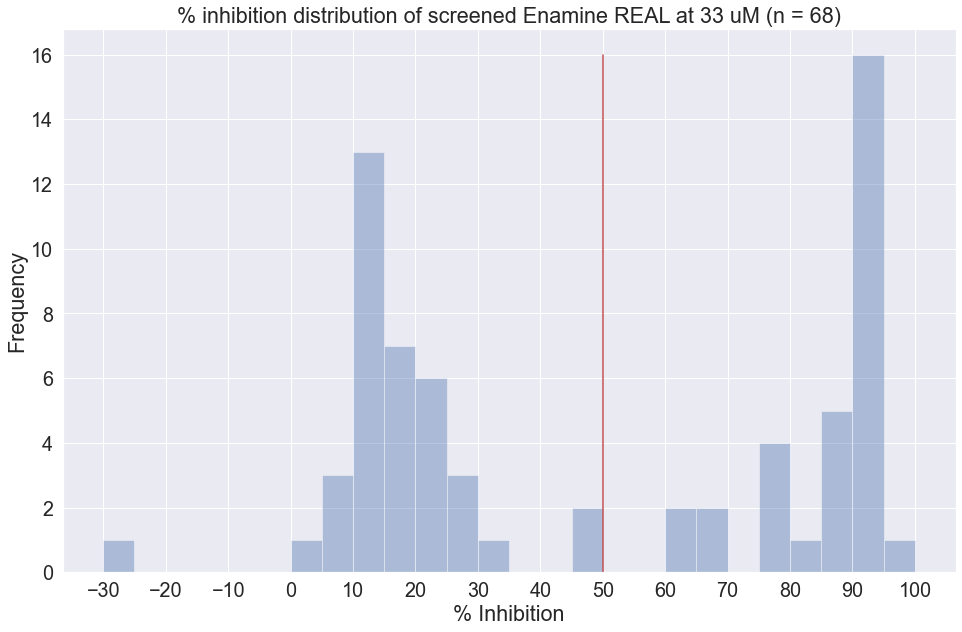

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

bin_range=[i for i in range(-30, 101) if i%5==0]
plt.figure(figsize=figsize)

sns.distplot(res_df[inhib_col], norm_hist=False, kde=False, bins=bin_range)
plt.plot([hit_thresh, hit_thresh], [0, 16], color='r')
plt.title('% inhibition distribution of screened Enamine REAL at 33 uM (n = {})'.format(res_df.shape[0]))
plt.xlabel(inhib_col); plt.xticks([i for i in range(-30, 101) if i%10==0]); plt.ylabel('Frequency')
plt.show()

---
## Total Hits of Ordered Compounds

In [5]:
counts, init_hits = scrutinized_df.shape[0], scrutinized_df['Hit_median_50_thresh'].sum()
scrutinized_hits = scrutinized_df['Scrutinized Hit'].sum()
summary_df = pd.DataFrame(data=[[counts, init_hits, 100.0*(init_hits/counts), scrutinized_hits, 100.0*(scrutinized_hits/counts)]],
                          columns=['Count', 'Initial Hits', 'Initial Hit Rate', 'Scrutinized Hits', 'Scrutinized Hit Rate'], 
                          index=['RF-C Enamine REAL'])
summary_df

Count  Initial Hits  Initial Hit Rate  Scrutinized Hits  \
RF-C Enamine REAL     68            31         45.588235                28   

                   Scrutinized Hit Rate  
RF-C Enamine REAL             41.176471

---
## Look at clusters/novel hits

Unique cluster hits counts the number of unique clusters with hits in the prospective dataset.

Novel cluster hits counts the number of unique clusters with hits that were NOT present in the training set. In other words, clusters that the model was not trained on. 

In [6]:
train_hits = train_and_ams_df[train_and_ams_df['Hit'] == 1]

cluster_cols = ['TB_0.4 ID']
cluster_summary = []
for df in [res_df]:
    ref_hits = df[df['Hit_median_50_thresh'] == 1]
    tmp_list = []
    for cluster_col in cluster_cols:
        cluster_hit_count = ref_hits[cluster_col].unique().shape[0]
        novel_cluster_count = np.setdiff1d(ref_hits[cluster_col].unique(), train_hits[cluster_col].unique()).shape[0]
        tmp_list.extend([cluster_hit_count, novel_cluster_count])
    cluster_summary.append(tmp_list)
cluster_hit_df = pd.DataFrame(data=cluster_summary,
                              columns=['Unique Cluster Hits (TB 0.4)', 'Novel Cluster Hits (TB 0.4)'],
                              index=['RF-C Enamine REAL'])
cluster_hit_df

Unique Cluster Hits (TB 0.4)  Novel Cluster Hits (TB 0.4)
RF-C Enamine REAL                            31                           31

In [7]:
summary_df = pd.concat([summary_df, cluster_hit_df], axis=1)
summary_df

Count  Initial Hits  Initial Hit Rate  Scrutinized Hits  \
RF-C Enamine REAL     68            31         45.588235                28   

                   Scrutinized Hit Rate  Unique Cluster Hits (TB 0.4)  \
RF-C Enamine REAL             41.176471                            31   

                   Novel Cluster Hits (TB 0.4)  
RF-C Enamine REAL                           31

In [8]:
cols = ['Is Train cluster?', 'Is Train active cluster?', 
        'Is AMS cluster?', 'Is AMS active cluster?']

res_hits = res_df[res_df['Hit_median_50_thresh'] == 1]
for c in cols:
    print(c, res_hits[c].sum())
    
res_hits[(res_hits['Is Train cluster?'] == 1) | (res_hits['Is AMS cluster?'] == 1)].shape

Is Train cluster? 4
Is Train active cluster? 0
Is AMS cluster? 2
Is AMS active cluster? 0


(5, 33)

---
## Compound Structures


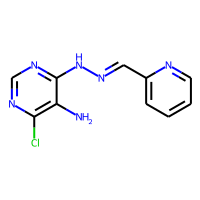
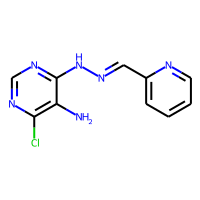
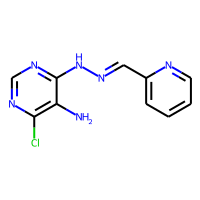
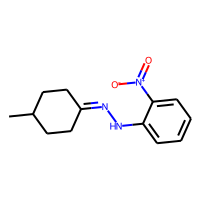
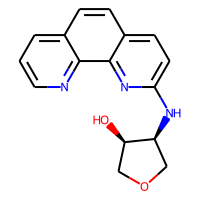
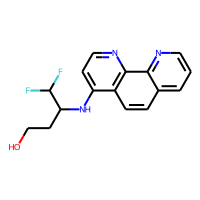
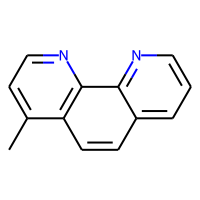
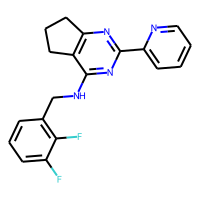
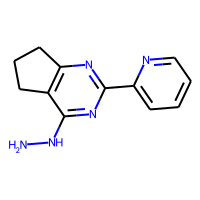
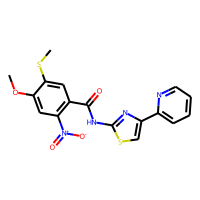
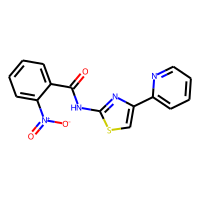
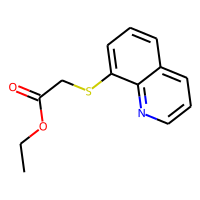
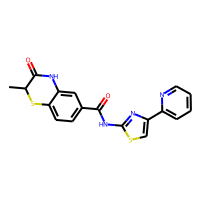
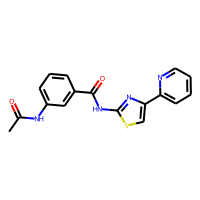
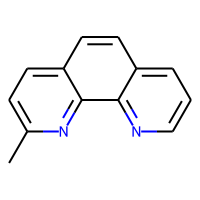
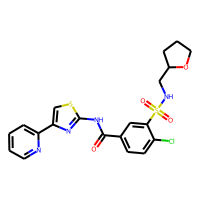
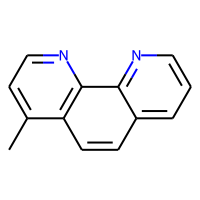
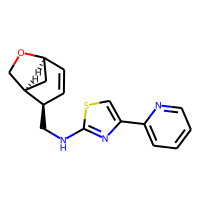
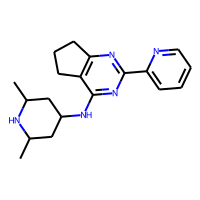
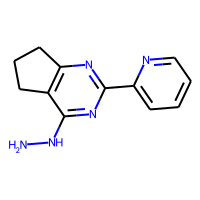
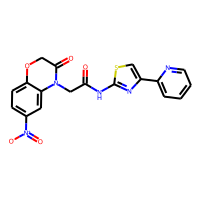
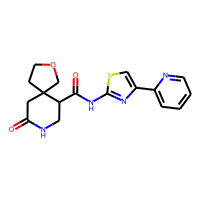
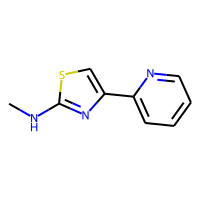
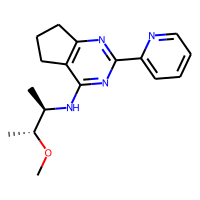
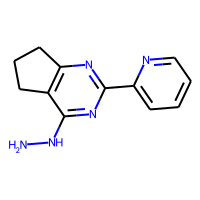
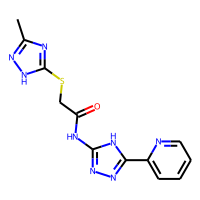
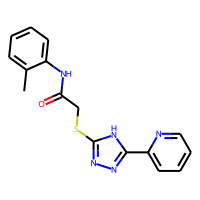
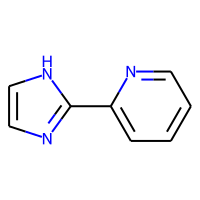
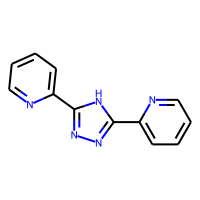
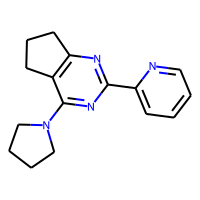
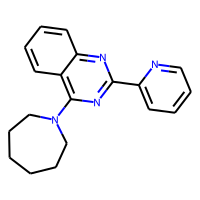
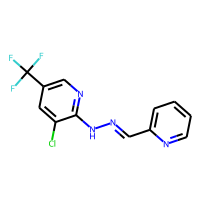
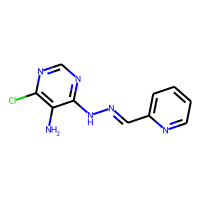
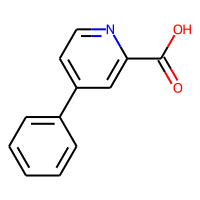
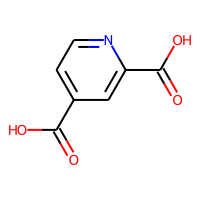
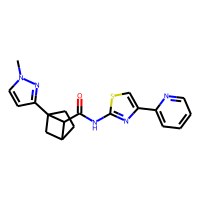
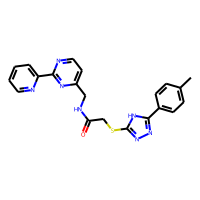
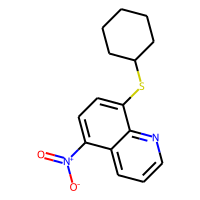
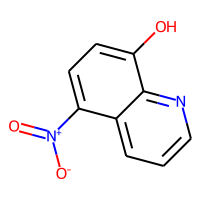
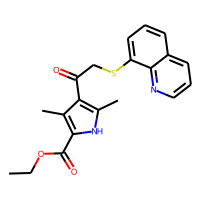
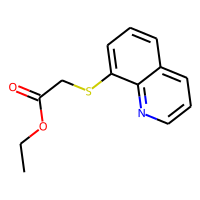
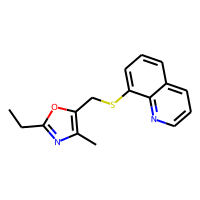
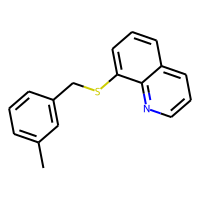
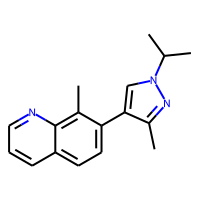
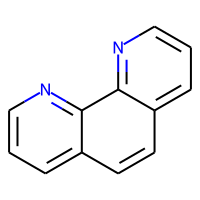
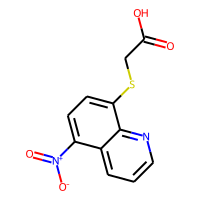
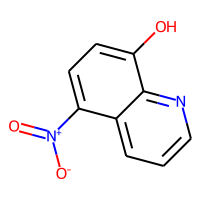
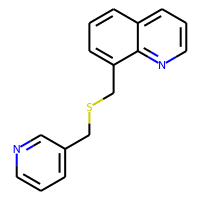
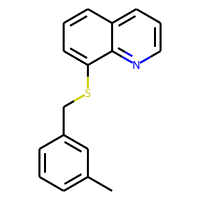
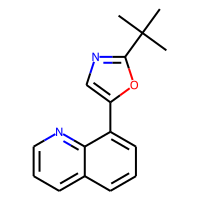
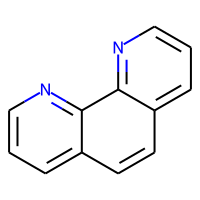
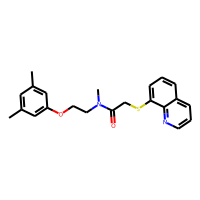
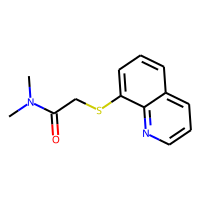
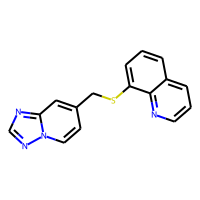
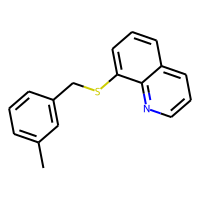
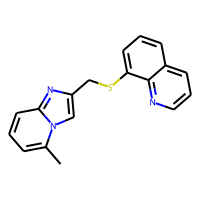
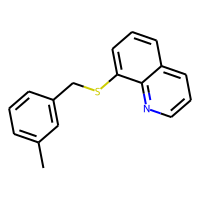
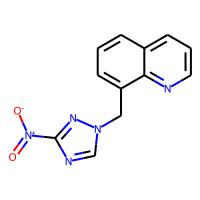
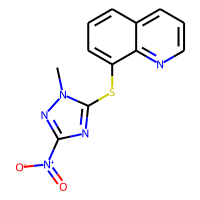
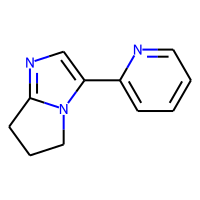
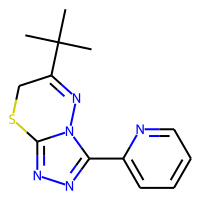
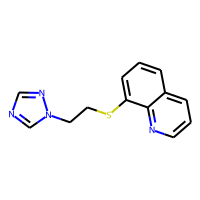
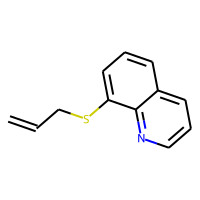
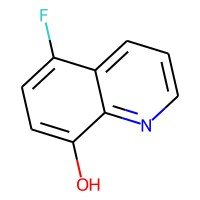
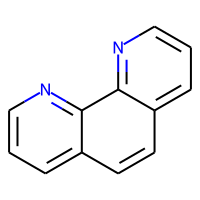
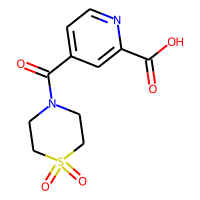
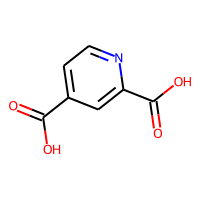
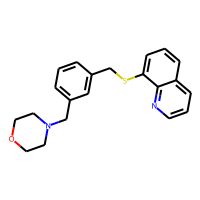
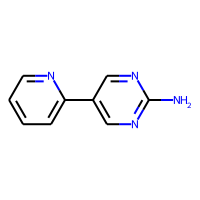
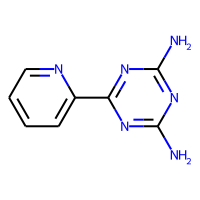
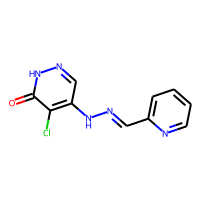
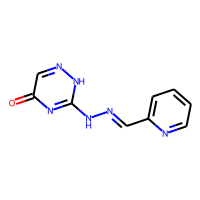
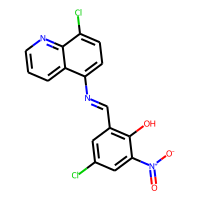
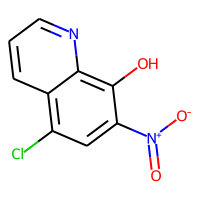
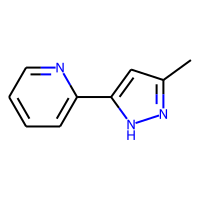
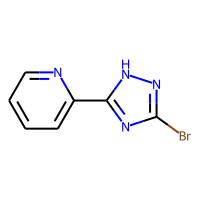
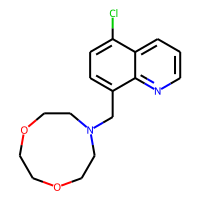
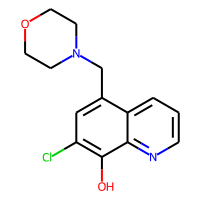
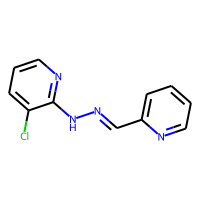
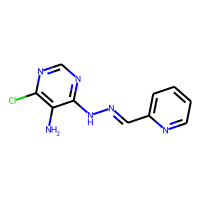
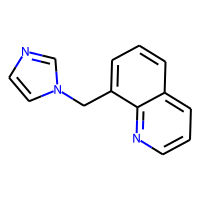
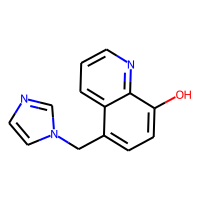
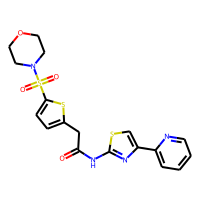
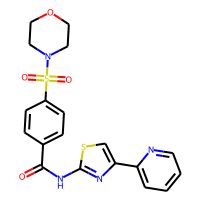
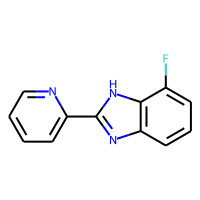
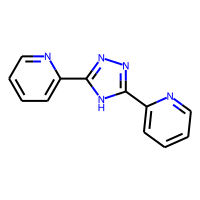
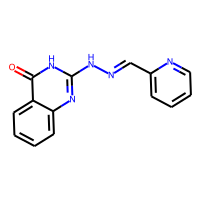
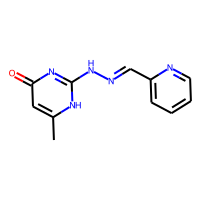
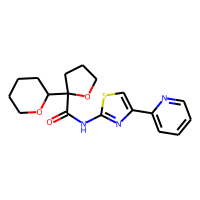
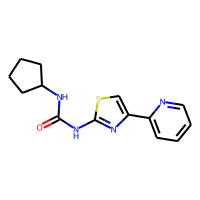
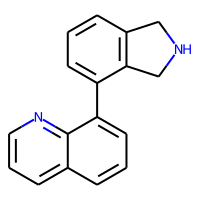
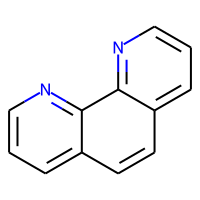
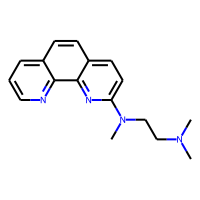
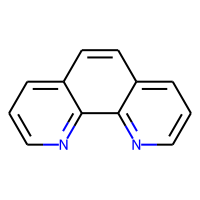
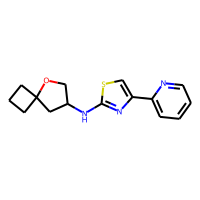
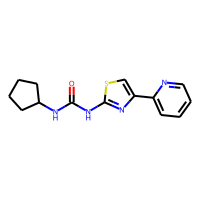
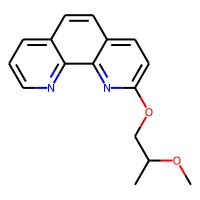
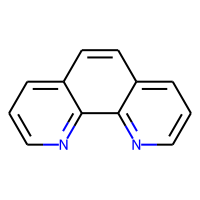
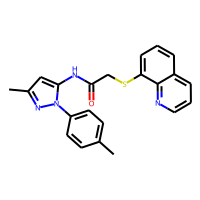
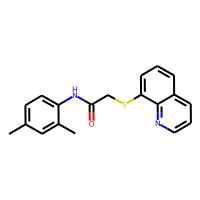
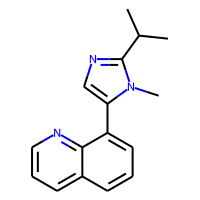
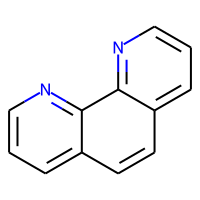
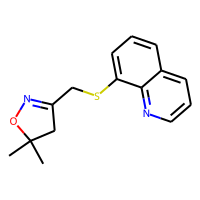
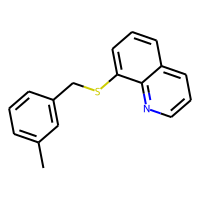
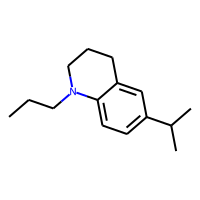
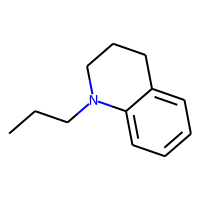
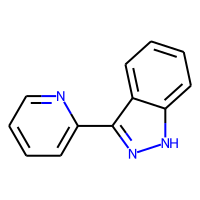
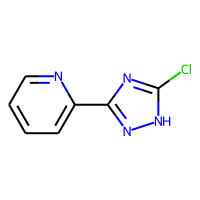

In [9]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from IPython.core.display import HTML
from rdkit.Chem import AllChem
PandasTools.RenderImagesInAllDataFrames(images=True)
DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0
from rdkit.Chem import rdFMCS

molid_col = 'ID Enamine'
inhib_col = '% Inhibition'
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
ic50_lower_col = 'PriA-SSB Dose response: IC50 CI (Lower) (uM)'
ic50_upper_col = 'PriA-SSB Dose response: IC50 CI (Upper) (uM)'
median_inhib_col = 'Median % negative control (%)'

ic50_vals = scrutinized_df[ic50_col].unique()

potency_dict = {}
for val in ic50_vals:
    try:
        potency_dict[val] = float(val)
    except:
        pass
potency_dict['> 66.0'] = 66.0
potency_dict['> 100'] = 100.0
potency_dict['< 4.17E-03'] = np.nan

scrutinized_df['Potency Order'] = 0
for i in range(scrutinized_df.shape[0]):
    scrutinized_df.loc[i, 'Potency Order'] = potency_dict[scrutinized_df.loc[i, ic50_col]]

def show(df): # see issue: https://github.com/rdkit/rdkit/issues/2673
    return HTML(df.to_html())

def get_sim_df(train_df, prosp_df):
    X_train_actives = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in train_df['1024 MorganFP Radius 2']]).astype(float)
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prosp_df['1024 MorganFP Radius 2']]).astype(float)
    train_prosp_tandist = pairwise_distances(X_prosp, X_train_actives, metric='jaccard')
    sim_info = []
    for i in range(train_prosp_tandist.shape[0]):
        prosp_smiles = prosp_df['rdkit SMILES'].iloc[i]; prosp_mol = Chem.MolFromSmiles(prosp_smiles);
        closest_active_idx = np.argmin(train_prosp_tandist[i,:]); 
        dist = train_prosp_tandist[i,closest_active_idx]
        train_smiles = train_df['rdkit SMILES'].iloc[closest_active_idx]; train_mol = Chem.MolFromSmiles(train_smiles);

        # try to align mols
        try:
            mcs = rdFMCS.FindMCS([train_mol, prosp_mol], ringMatchesRingOnly=True, completeRingsOnly=True)
            template = Chem.MolFromSmarts(mcs.smartsString)
            AllChem.Compute2DCoords(template, nSample=500, sampleSeed=20211337)
            AllChem.GenerateDepictionMatching2DStructure(train_mol, template)
            AllChem.GenerateDepictionMatching2DStructure(prosp_mol, template)
        except:
            pass
        
        dataset_name = train_df['dataset'].iloc[closest_active_idx]
        if dataset_name == 'train':
            dataset_name = 'Training'
        elif dataset_name == 'ams':
            dataset_name = 'AMS'
        dataset_dist = '{}: {:.2f}'.format(dataset_name, dist)
        
        initial_hit = prosp_df['Hit_median_50_thresh'].iloc[i]
        scrutinized_hit = prosp_df['Scrutinized Hit'].iloc[i]
        ic50_val = prosp_df[ic50_col].iloc[i]
        ic50_lower_val = prosp_df[ic50_lower_col].iloc[i]
        ic50_upper_val = prosp_df[ic50_upper_col].iloc[i]
        potency_order = prosp_df['Potency Order'].iloc[i]
            
        sim_info.append((prosp_df[molid_col].iloc[i], prosp_mol, train_mol, dataset_dist, dist, 
                         initial_hit, scrutinized_hit, 
                         ic50_val, ic50_lower_val, ic50_upper_val, potency_order))
        
    sim_df = pd.DataFrame(data=sim_info, 
                          columns=['Mol ID', 'Prospective Mol', 'Nearest Training or AMS Active', 
                                   'Dataset:Tanimoto Distance',  'Tanimoto Distance', 
                                   'Initial Hit', 'Scrutinized Hit', 
                                   ic50_col, ic50_lower_col, ic50_upper_col, 'Potency Order'])
    sim_df = sim_df.sort_values('Potency Order', ascending=True).reset_index(drop=True)
    sim_df = sim_df.drop('Potency Order', axis=1)
    return sim_df


train_ams_actives = train_and_ams_df[train_and_ams_df['Hit'] == 1]
scrutinized_hits_df = scrutinized_df[scrutinized_df['Scrutinized Hit'] == 1]
sim_df = get_sim_df(train_ams_actives, scrutinized_df)
sim_hits_df = get_sim_df(train_ams_actives, scrutinized_hits_df)
show(sim_df)

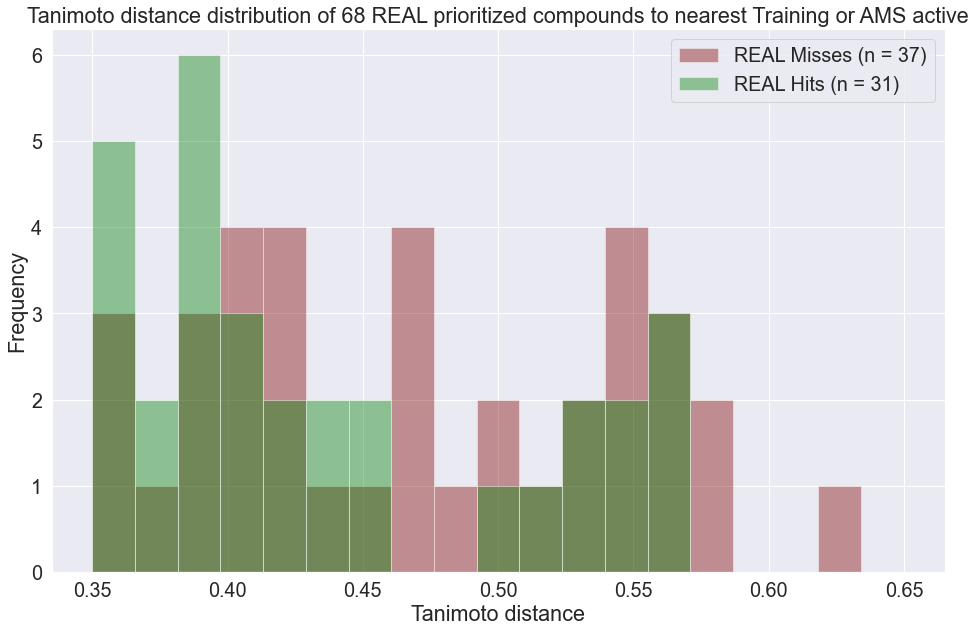

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

tan_dist = sim_df['Tanimoto Distance'].values
bin_range= np.linspace(0.35, 0.65, 20) #[0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65] #np.linspace(0.35, 0.65, 10)
plt.figure(figsize=figsize)
prosp_hits_dist = sim_df[sim_df['Initial Hit'] == 1]['Tanimoto Distance'].values
prosp_misses_dist = sim_df[sim_df['Initial Hit'] == 0]['Tanimoto Distance'].values

sns.distplot(prosp_misses_dist, bins=bin_range, norm_hist=False, kde=False, color='maroon')  
sns.distplot(prosp_hits_dist, bins=bin_range, norm_hist=False, kde=False, color='green')  
plt.title('Tanimoto distance distribution of 68 REAL prioritized compounds to nearest Training or AMS active')
plt.xlabel('Tanimoto distance'); plt.ylabel('Frequency');
plt.legend(['REAL Misses (n = {})'.format(prosp_misses_dist.shape[0]), 
            'REAL Hits (n = {})'.format(prosp_hits_dist.shape[0])])
plt.show()

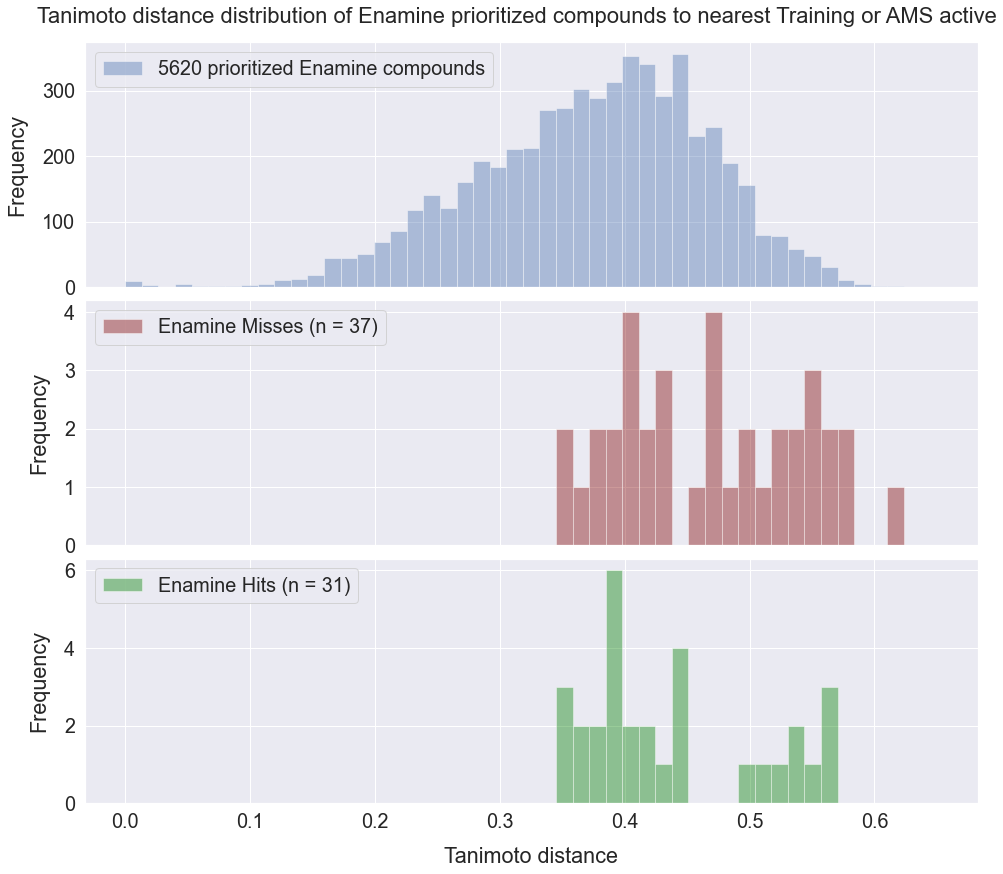

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 14)

tan_dist = sim_df['Tanimoto Distance'].values
bin_range= np.linspace(0.0, 0.65, 50) 
prosp_hits_dist = sim_df[sim_df['Initial Hit'] == 1]['Tanimoto Distance'].values
prosp_misses_dist = sim_df[sim_df['Initial Hit'] == 0]['Tanimoto Distance'].values
legends = ['5620 prioritized Enamine compounds',
           'Enamine Misses (n = {})'.format(prosp_misses_dist.shape[0]), 
           'Enamine Hits (n = {})'.format(prosp_hits_dist.shape[0])]

fig, axes = plt.subplots(3,1, figsize=figsize, sharex=True)

#plt.title('Tanimoto distance distribution of 5620 purchaseable Enamine REAL\n compounds to nearest Training or AMS active')
tan_5620_dist = top_real_clustering[['Closest Train Active TanDist', 'Closest AMS Active TanDist']].min(axis=1).values
sns.distplot(tan_5620_dist, bins=bin_range, norm_hist=False, kde=False, ax=axes[0])  
sns.distplot(prosp_misses_dist, bins=bin_range, norm_hist=False, kde=False, ax=axes[1], color='maroon')
sns.distplot(prosp_hits_dist, bins=bin_range, norm_hist=False, kde=False, ax=axes[2],color='green')

for i, ax in enumerate(axes):
    #ax.set_xlim([0.35,0.65])
    #ax.set_ylim([0,9.5])
    #ax.set_xticks([int(i) for i in np.linspace(35, 165, 14)])
    ax.set_ylabel('Frequency', labelpad=15);
    ax.legend([legends[i]], loc='upper left')
    
plt.subplots_adjust(wspace=0, hspace=0.055)
plt.xlabel('Tanimoto distance', labelpad=15)
plt.suptitle('Tanimoto distance distribution of Enamine prioritized compounds to nearest Training or AMS active', 
             y=.915, fontsize=22)
plt.show()

---
## Similarity Heatmaps

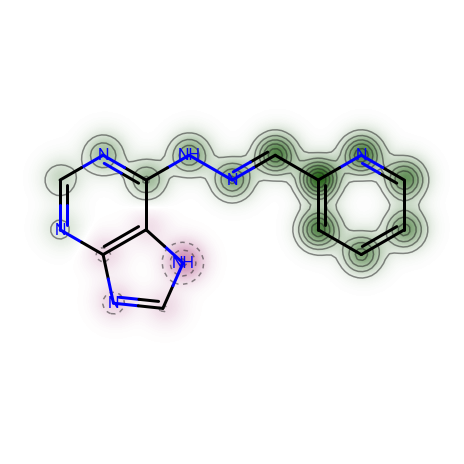

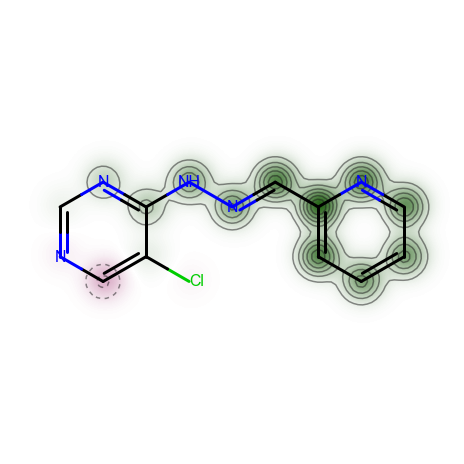

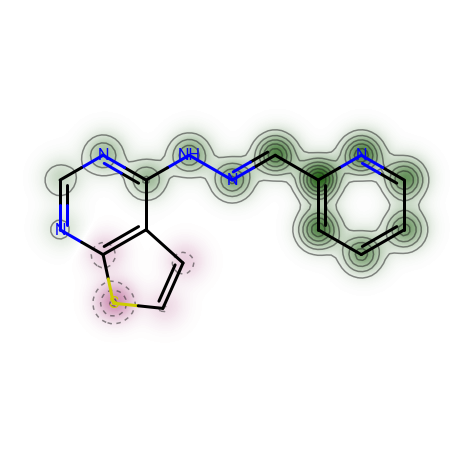

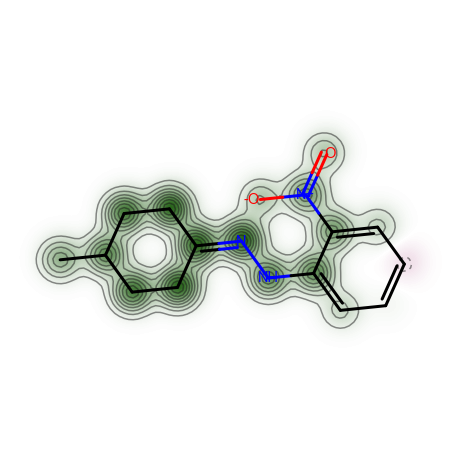

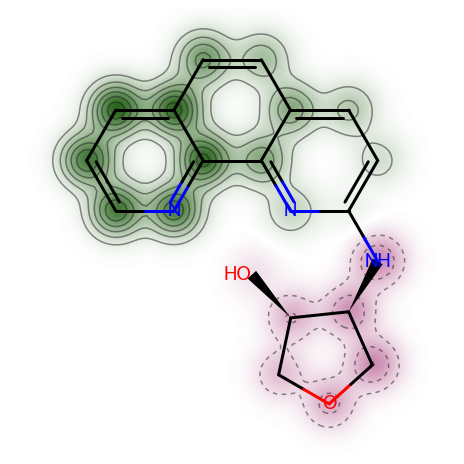

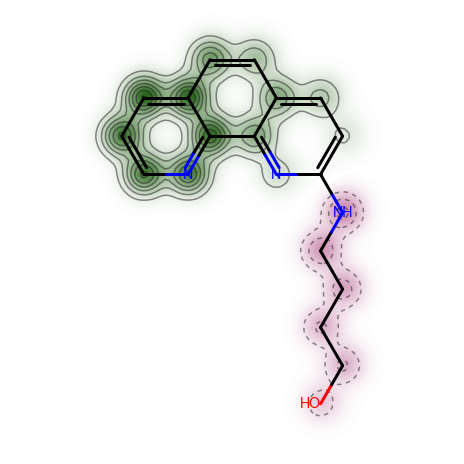

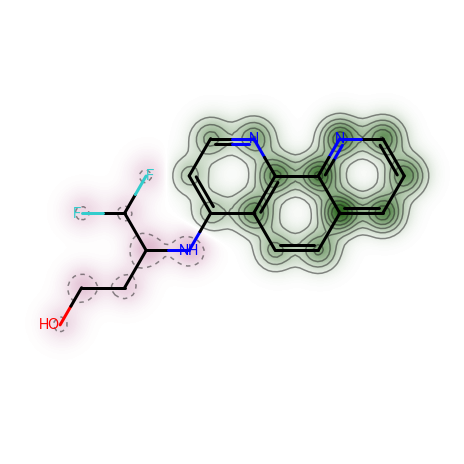

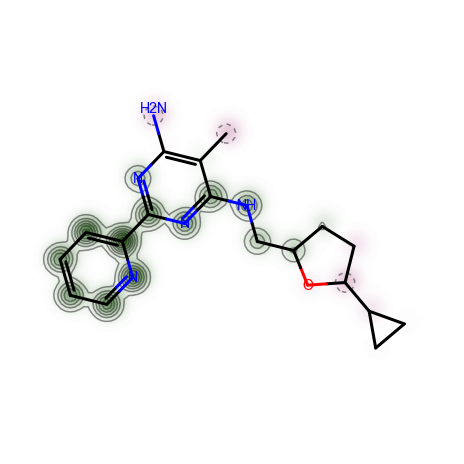

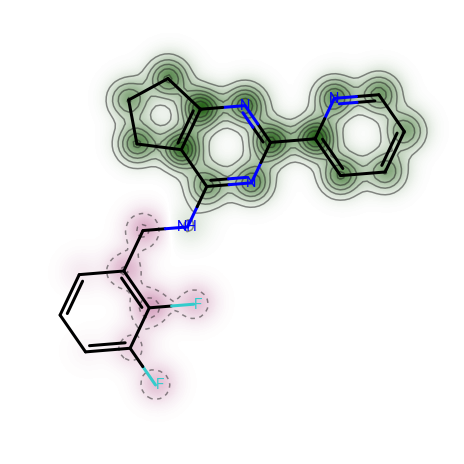

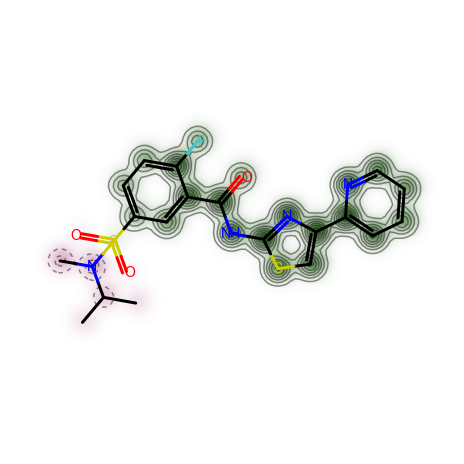

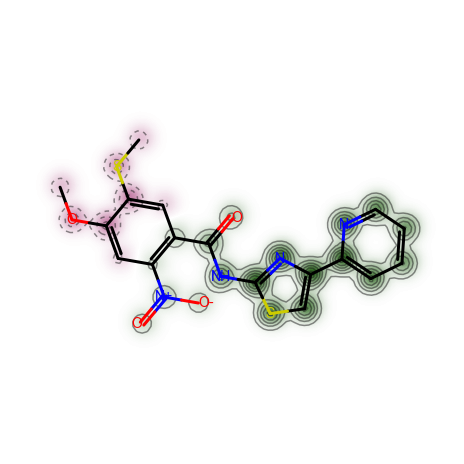

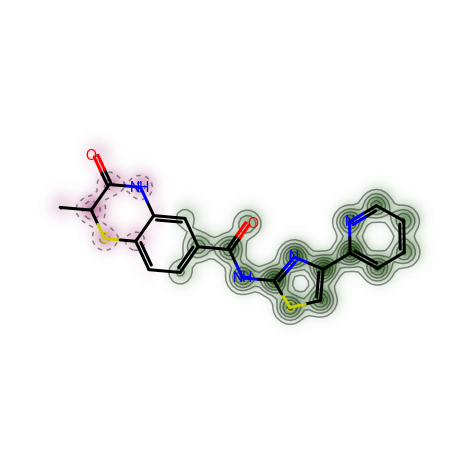

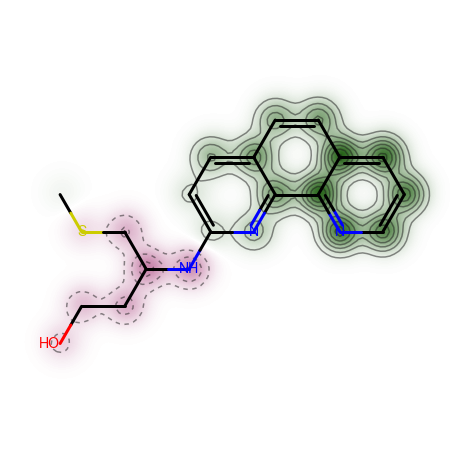

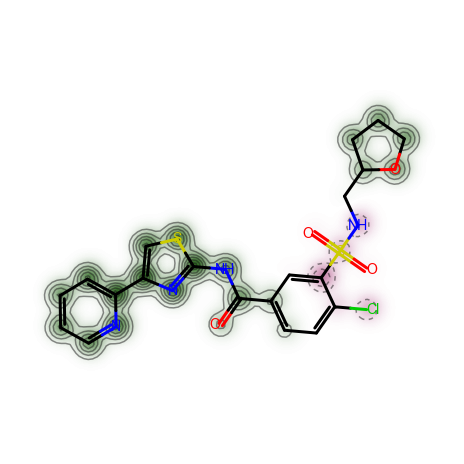

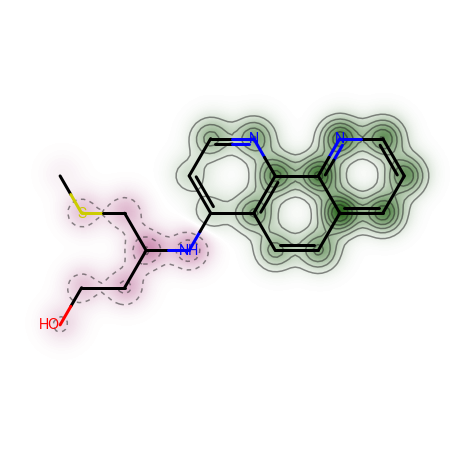

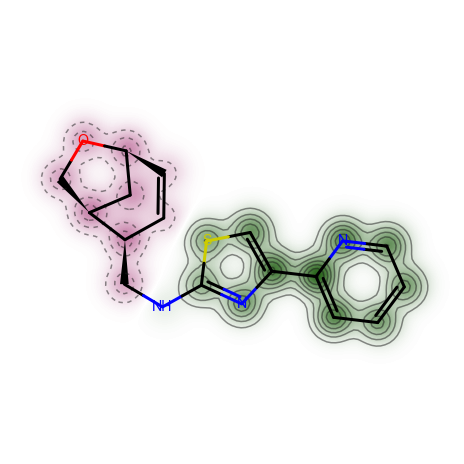

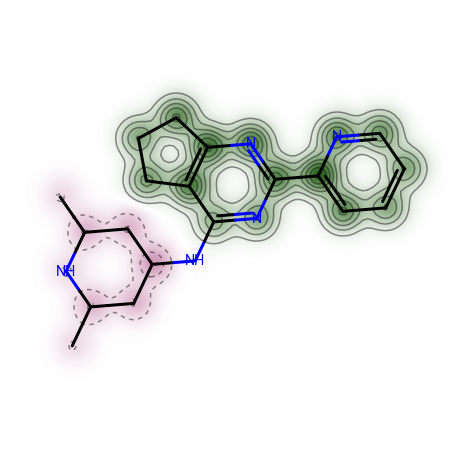

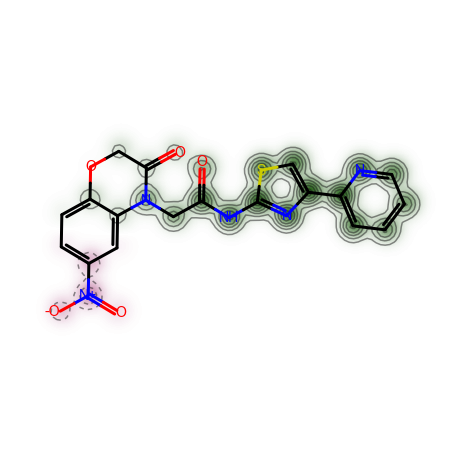

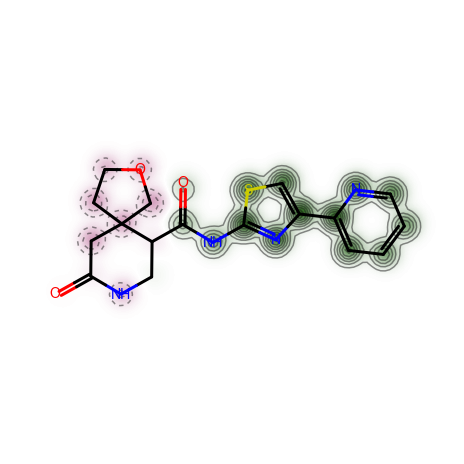

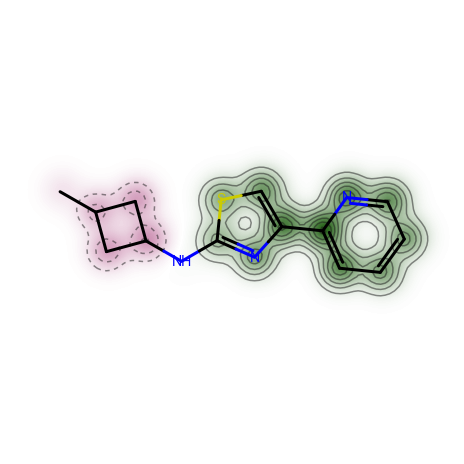

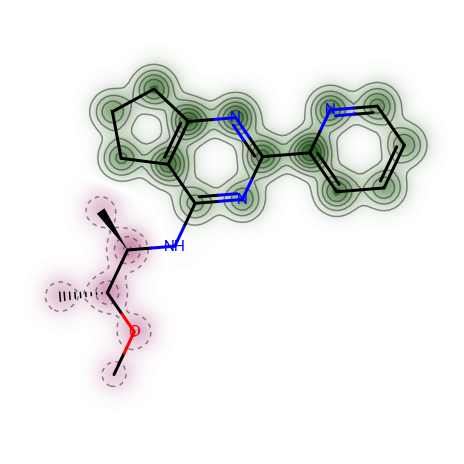

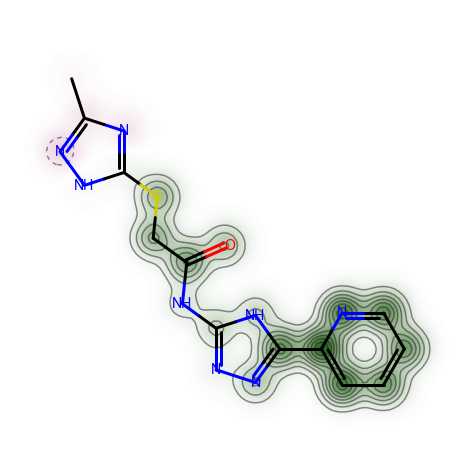

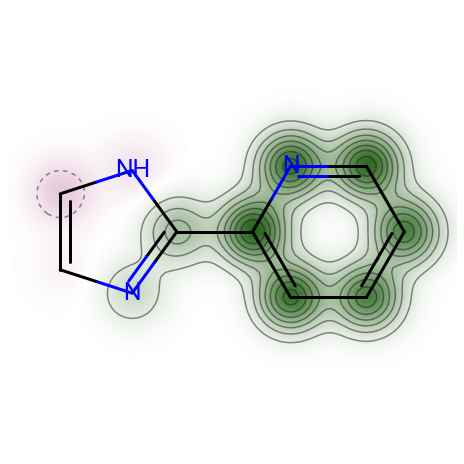

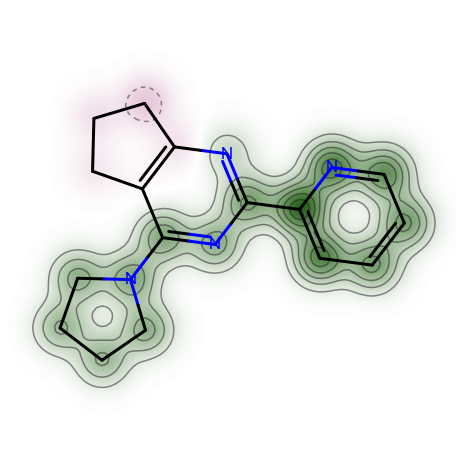

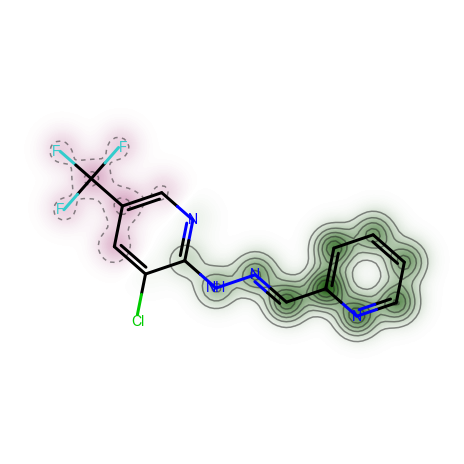

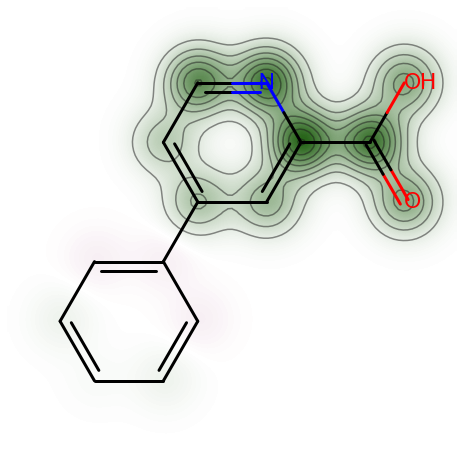

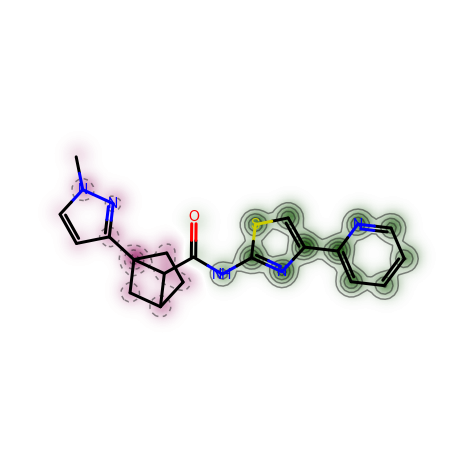

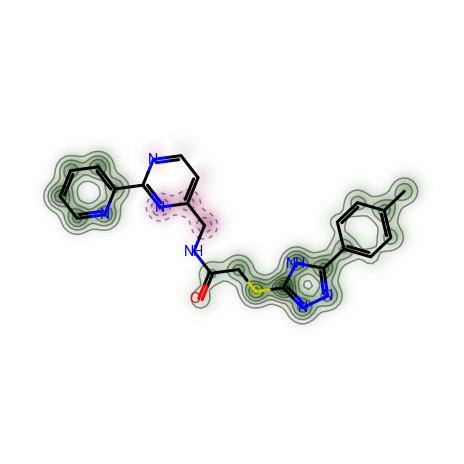

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Draw import SimilarityMaps
FP_radius=2
x = sim_hits_df.copy() #sim_df[sim_df['Is Hit?'] == 1]

for i in range(x.shape[0]):
    Draw.MolToFile(x.iloc[i,1], "./real_results_vis/rf_{}_{}.png".format(i, 'prosp'))
    Draw.MolToFile(x.iloc[i,2], "./real_results_vis/rf_{}_{}.png".format(i, 'train'))
    
    prosp_mol = x.iloc[i,1]
    train_mol = x.iloc[i,2]
    
    sim_func = (lambda a, b: SimilarityMaps.GetMorganFingerprint(a, atomId=b, fpType='bv', radius=FP_radius, nBits=1024))
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(train_mol, prosp_mol, sim_func)
        
    fig.savefig("./real_results_vis/rf_{}_{}.png".format(i, 'hmap'), bbox_inches='tight')

In [ ]:
###### prefix = '\Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/'
image_fmt = 'rf_{}_{}'
row_fmt = '{} & {} & {} & {} & {} ({}, {}) \\\\'
sim_hits_df = sim_hits_df.round(2)
sim_hits_df[ic50_lower_col] = sim_hits_df[ic50_lower_col].astype(float).round(1)
sim_hits_df[ic50_upper_col] = sim_hits_df[ic50_upper_col].astype(float).round(1)
sim_hits_df[ic50_col] = sim_hits_df[ic50_col].astype(float).round(1)

prefix = '\\Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\\linewidth]{figures/real/real_vis/'
for i, row in sim_hits_df.iterrows():
    dataset_tandist = row['Tanimoto Distance']
    mol_id = '{\\footnotesize ' + row['Mol ID'] +'}'
    
    ic50_val = row[ic50_col]
    ic50_lower = row[ic50_lower_col]
    ic50_upper = row[ic50_upper_col]
        
    x1 = '\makecell{' + prefix + image_fmt.format(i, 'prosp.png}') + '\\\\' + mol_id + '}'
    x2 = '\makecell{' + prefix + image_fmt.format(i, 'train.png}') + '\\\\\\hfill}'
    x3 = '\makecell{' + prefix + image_fmt.format(i, 'hmap.png}') + '\\\\\\hfill}'
    
    row_string = row_fmt.format(x1, x2, x3, dataset_tandist, ic50_val, ic50_lower, ic50_upper)
    print(row_string)
    print('\\hline')